# Deep Learning Approach #1 - Unet w/ ResNet Backbone for Segmentation
We found a downstream task similar to our goal where a team of reasearchers had a series of MRI lung scans and were tasked with classifing the afflicted regions of different lung diseases including COVID-19 usin segmented regions and labelling those regions with which class of affliction. Here is the paper where they did this https://pmc.ncbi.nlm.nih.gov/articles/PMC9497601/. 

### Import Required Packages and Global Variables

In [14]:
# Import all necessary packages
import os, time
import numpy as np
# import cv2
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from tqdm import tqdm

# Global Constraints
# Dimensions of the image inputs into Unet after resizing
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
# Configurable in case of hardware limitations
EPOCHS = 25
LR = 0.001
# Paths to the data directories
RGB_DIR = 'USA_segmentation/RGB_images'
NIR_DIR = 'USA_segmentation/NRG_images'
MASK_DIR = 'USA_segmentation/masks'
# Test proportion of full dataset
TEST_SIZE = 0.2
RANDOM_SEED = 42

### Retrieve and Split Labelled Data
The data from our project directory has to be read and split in order to be processed and used for training the Unet model. Fortunately the corrspondong image types have corresponding names, so creating a tuple of lists to contain the RGB, NRG, and mask images is just a matter if isolating the image tage common between all of the corresponding file names. 

In [15]:
# Read in file paths from given directories and splits them into train and test sets
# Args:
#   rgb_dir (str): Path from current file directory containing the RGB photos
#   nir_dir (str): Path from current file directory containing the NIR photos
#   mask_dir (str): Path from current file directory containing the masks
#   test_size (float): Proportion of entire dataset contributed to tests
#   random_state (int): Random seed
# Returns:
#   tuple: A tuple containin two lists (train_data, test_data)
def read_and_split_data(rgb_dir, nir_dir, mask_dir, test_size=TEST_SIZE, random_state=RANDOM_SEED):
    # Get all RGB images sorted 
    rgb_files = sorted(glob(os.path.join(rgb_dir, "RGB_*.png")))
    
    
    tags = [os.path.basename(f).replace("RGB_", "").replace(".png", "") for f in rgb_files]
    print(f"Num of tags: {len(tags)}")
    pairs = []
    # Iterate though each identifying tag to find corresponding RGB, NIR, and masks
    for tag in tags:
        rgb_path = os.path.join(rgb_dir, f"RGB_{tag}.png")
        nir_path = os.path.join(nir_dir, f"NRG_{tag}.png")
        mask_path = os.path.join(mask_dir, f"mask_{tag}.png")
        
        # Check if all three corresponding files exist
        if os.path.exists(rgb_path) and os.path.exists(nir_path) and os.path.exists(mask_path):
            pairs.append({
                'rgb': rgb_path,
                'nir': nir_path,
                'mask': mask_path,
                'tag': tag
            })
        else:
            print(f"Skipping the {tag} file due to a missing file.")
            
    if not pairs:
        raise ValueError("No complete data pairs were found")
    else:
        print(f"Num of pairs: {len(pairs)}")
    
    # Split the collected data pairs into training and testing sets
    train_data, test_data = train_test_split(pairs, test_size=test_size, random_state=random_state)
    print(f"Total samples found: {len(pairs)}")
    print(f"Train samples: {len(train_data)}")
    print(f"Test samples: {len(test_data)}")
    
    return train_data, test_data
    
train, test = read_and_split_data(RGB_DIR, NIR_DIR, MASK_DIR)


Num of tags: 444
Num of pairs: 444
Total samples found: 444
Train samples: 355
Test samples: 89


### Dataset Object Initialization

In [27]:
# Initializes a custom dataset class for loading and preprocessing the forest images
# Args:
#   data_pairs (list): list of dicts with each entry having paths to rgb, nir, and mask
#   image_size (tuple): The target (width, height) for resizing images
class ForestDataset(Dataset):
    def __init__(self, data_pairs, image_size, transform=None):
        self.data_pairs = data_pairs
        self.image_size = image_size
        self.transform = transform

    # Returns the total number of samples in the dataset
    def __len__(self):
        return len(self.data_pairs)

    # Loads, preprocesses, and returns a single sample (input image and mask)
    # Args:
    #     idx (int): Index of the sample to retrieve
    # Returns:
    #     tuple: A tuple containing the preprocessed input tensor (4 channels)
    #            and the mask tensor (1 channel) and the original RGB image path
    def __getitem__(self, idx):
        item = self.data_pairs[idx]
        rgb_path = item['rgb']
        nir_path = item['nir']
        mask_path = item['mask']

        # Load images using PIL
        # RGB image is converted to 'RGB'
        # NIR and mask images are converted to 'L' (grayscale)
        rgb_image = Image.open(rgb_path).convert("RGB")
        nir_image = Image.open(nir_path).convert("L")
        mask_image = Image.open(mask_path).convert("L")

        # Resize images to the specified IMAGE_SIZE
        rgb_image = rgb_image.resize(self.image_size)
        nir_image = nir_image.resize(self.image_size)
        mask_image = mask_image.resize(self.image_size)

        # Convert PIL images to NumPy arrays and normalize pixel values to [0, 1]
        # RGB: (H, W, 3)
        # NIR: (H, W)
        # Mask: (H, W)
        rgb_np = np.array(rgb_image).astype(np.float32) / 255.0
        nir_np = np.array(nir_image).astype(np.float32) / 255.0
        mask_np = np.array(mask_image).astype(np.float32) / 255.0

        # Ensure the mask is strictly binary (0 or 1)
        mask_np[mask_np > 0.5] = 1.0
        mask_np[mask_np <= 0.5] = 0.0

        # Convert NumPy arrays to PyTorch tensors.
        # PyTorch expects image tensors in (C, H, W) format
        # RGB (H, W, 3) -> (3, H, W)
        rgb_tensor = torch.from_numpy(rgb_np).permute(2, 0, 1)
        # NIR (H, W) -> (1, H, W) by adding a channel dimension
        nir_tensor = torch.from_numpy(nir_np).unsqueeze(0)

        # Concatenate RGB and NIR tensors along the channel dimension to create a 4-channel input
        input_tensor = torch.cat((rgb_tensor, nir_tensor), dim=0)

        # Mask tensor also needs a channel dimension (1, H, W) for the loss function
        mask_tensor = torch.from_numpy(mask_np).unsqueeze(0)

        # Apply additional transforms if provided 
        if self.transform:
            input_tensor = self.transform(input_tensor)
            # Apply transform to mask if it's a spatial transform like rotation/flip
            mask_tensor = self.transform(mask_tensor)

        return input_tensor, mask_tensor, rgb_path

###  Define and Train Unet Segmentation Model 

In [17]:
# Trains a U-Net segmentation model using the provided training data
# Args:
#     train_data (list): List of dictionaries containing training image paths
#     num_epochs (int): Number of epochs to train the model
#     batch_size (int): Number of samples per batch
#     learning_rate (float): Learning rate for the optimizer
#     image_size (tuple): Target image size (width, height)
# Returns:
#     tuple: A tuple containing the trained model and the total training time in seconds
def train_unet_model(train_data, num_epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LR, image_size=IMAGE_SIZE):

    # Determine the device to use (GPU or CPU).
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device for training: {device}")

    # Initialize the training dataset and data loader
    # Data transformation can be added here if more augmentations are desired
    train_dataset = ForestDataset(train_data, image_size, transform=None)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() // 2 or 1)

    # Initialize the U-Net model 
    # 'resnet34' aws our backbone, pretrained on imagenet
    # in_channels=4 from 3 RGB channels and 1 NIR channel
    # classes=1 for binary segmentation (dead trees vs. background)
    # activation=None, BCEWithLogitsLoss handles the sigmoid activation internally
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=4,
        classes=1,
        activation=None
    )
    model.to(device) 

    # Define the loss function and optimizer
    # BCEWithLogitsLoss is numerically stable and recommended for binary segmentation
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time() 

    # Training loop
    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        # Iterate over batches from the training data loader
        for inputs, masks, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device) 
            masks = masks.to(device)   

            optimizer.zero_grad() 
            outputs = model(inputs) 
            loss = loss_function(outputs, masks) 
            loss.backward() 
            optimizer.step() 

            running_loss += loss.item() * inputs.size(0) 

        epoch_loss = running_loss / len(train_dataset) 
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    end_time = time.time() 
    training_time = end_time - start_time
    print(f"Training finished in {training_time:.2f} seconds.")

    return model, training_time

### Fine Tuning/Training

# Evaluation

In [ ]:
# Evaluates the trained segmentation model on the test dataset.
# Args:
#     model (torch.nn.Module): The trained U-Net model.
#     test_data (list): List of dictionaries containing test image paths.
#     image_size (tuple): Target image size (width, height).
#     batch_size (int): Number of samples per batch.
# Returns:
#     tuple: A tuple containing the mean IoU score and the total testing time in seconds.
def evaluate_model(model, test_data, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, num_display_samples=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device for evaluation: {device}")

    # Initialize the test dataset and data loader
    test_dataset = ForestDataset(test_data, image_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count() // 2 or 1)

    model.eval() 
    all_preds = [] 
    all_masks = [] 

    # Randomly select a few samples to display
    display_indices = np.random.choice(len(test_dataset), min(num_display_samples, len(test_dataset)), replace=False)

    print("Starting model evaluation...")
    start_time = time.time() 

    # Disable gradient calculation during inference to save memory and speed up computation
    with torch.no_grad():
        for batch_idx, (inputs, masks, rgb_paths) in enumerate(tqdm(test_loader, desc="Evaluating")):
            inputs = inputs.to(device)
            masks = masks.to(device)  

            outputs = model(inputs) 
            # Apply sigmoid to outputs to get probabilities, then threshold at 0.5 for binary predictions
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            
            # Move predictions and masks to CPU and convert to NumPy
            all_preds.append(preds.cpu().numpy()) 
            all_masks.append(masks.cpu().numpy()) 
            
            for i in range(inputs.shape[0]):
                global_idx = batch_idx * batch_size + i
                if global_idx in display_indices:
                    # Get the predicted and ground truth masks
                    pred_mask_np = preds[i].cpu().squeeze().numpy()
                    gt_mask_np = masks[i].cpu().squeeze().numpy()
                    
                    # Load the original RGB image for visualization
                    original_rgb_path = rgb_paths[i]
                    original_rgb = Image.open(original_rgb_path).convert('RGB')
                    original_rgb = original_rgb.resize(image_size)
                    original_rgb_np = np.array(original_rgb)
                
                    # Create a figure with three subplots
                    plt.figure(figsize=(18, 6))
                    
                    # Original RGB Image
                    plt.subplot(1, 3, 1)
                    plt.imshow(original_rgb_np)
                    plt.title(f"Original RGB Image (Sample {global_idx})")
                    plt.axis('off')
                    
                    # Predicted Mask Overlay
                    plt.subplot(1, 3, 2)
                    plt.imshow(original_rgb_np)
                    masked_pred = np.ma.masked_where(pred_mask_np == 0, pred_mask_np)
                    plt.imshow(masked_pred, cmap='Reds', alpha=0.5)
                    plt.title("Predicted Segmentation")
                    plt.axis('off')
                    
                    # Subplot 3: Ground Truth Mask Overlay
                    plt.subplot(1, 3, 3)
                    plt.imshow(original_rgb_np)
                    masked_gt = np.ma.masked_where(gt_mask_np == 0, gt_mask_np)
                    plt.imshow(masked_gt, cmap='Greens', alpha=0.5)
                    plt.title("Ground Truth Mask")
                    plt.axis('off')
                    
                    # plt.tight_layout()
                    plt.show()
                    
    end_time = time.time() 
    testing_time = end_time - start_time
    print(f"Evaluation finished in {testing_time:.2f} seconds.")

    # Concatenate all predictions and masks into single numpy arrays
    all_preds = np.vstack(all_preds)
    all_masks = np.vstack(all_masks)

    # Small smoothing value to avoid division by zero
    epsilon = 1e-6 

    # Calculate IoU for each image
    intersection = (all_preds * all_masks).sum(axis=(1, 2, 3)) 
    union = (all_preds + all_masks).sum(axis=(1, 2, 3)) - intersection
    iou_scores = (intersection + epsilon) / (union + epsilon) 
    
    # Calculate the mean IoU across all test samples.
    mean_iou = np.mean(iou_scores) 
    print(f"Mean IoU (Jaccard Similarity Coefficient): {mean_iou:.4f}")

    return mean_iou, testing_time

Num of tags: 444
Num of pairs: 444
Total samples found: 444
Train samples: 355
Test samples: 89
Using device for training: cuda


Epoch 1/25: 100%|██████████| 45/45 [00:06<00:00,  6.83it/s]


Epoch 1/25, Loss: 0.2499


Epoch 2/25: 100%|██████████| 45/45 [00:05<00:00,  7.99it/s]


Epoch 2/25, Loss: 0.0811


Epoch 3/25: 100%|██████████| 45/45 [00:05<00:00,  8.03it/s]


Epoch 3/25, Loss: 0.0660


Epoch 4/25: 100%|██████████| 45/45 [00:05<00:00,  8.06it/s]


Epoch 4/25, Loss: 0.0592


Epoch 5/25: 100%|██████████| 45/45 [00:05<00:00,  8.06it/s]


Epoch 5/25, Loss: 0.0553


Epoch 6/25: 100%|██████████| 45/45 [00:05<00:00,  8.09it/s]


Epoch 6/25, Loss: 0.0545


Epoch 7/25: 100%|██████████| 45/45 [00:05<00:00,  7.90it/s]


Epoch 7/25, Loss: 0.0504


Epoch 8/25: 100%|██████████| 45/45 [00:05<00:00,  7.94it/s]


Epoch 8/25, Loss: 0.0480


Epoch 9/25: 100%|██████████| 45/45 [00:05<00:00,  7.89it/s]


Epoch 9/25, Loss: 0.0471


Epoch 10/25: 100%|██████████| 45/45 [00:05<00:00,  7.89it/s]


Epoch 10/25, Loss: 0.0448


Epoch 11/25: 100%|██████████| 45/45 [00:05<00:00,  7.77it/s]


Epoch 11/25, Loss: 0.0435


Epoch 12/25: 100%|██████████| 45/45 [00:05<00:00,  7.65it/s]


Epoch 12/25, Loss: 0.0456


Epoch 13/25: 100%|██████████| 45/45 [00:05<00:00,  7.55it/s]


Epoch 13/25, Loss: 0.0414


Epoch 14/25: 100%|██████████| 45/45 [00:05<00:00,  7.72it/s]


Epoch 14/25, Loss: 0.0408


Epoch 15/25: 100%|██████████| 45/45 [00:05<00:00,  7.64it/s]


Epoch 15/25, Loss: 0.0397


Epoch 16/25: 100%|██████████| 45/45 [00:05<00:00,  7.66it/s]


Epoch 16/25, Loss: 0.0388


Epoch 17/25: 100%|██████████| 45/45 [00:05<00:00,  7.62it/s]


Epoch 17/25, Loss: 0.0386


Epoch 18/25: 100%|██████████| 45/45 [00:05<00:00,  7.52it/s]


Epoch 18/25, Loss: 0.0371


Epoch 19/25: 100%|██████████| 45/45 [00:05<00:00,  7.69it/s]


Epoch 19/25, Loss: 0.0350


Epoch 20/25: 100%|██████████| 45/45 [00:05<00:00,  7.67it/s]


Epoch 20/25, Loss: 0.0337


Epoch 21/25: 100%|██████████| 45/45 [00:05<00:00,  7.64it/s]


Epoch 21/25, Loss: 0.0316


Epoch 22/25: 100%|██████████| 45/45 [00:06<00:00,  7.49it/s]


Epoch 22/25, Loss: 0.0310


Epoch 23/25: 100%|██████████| 45/45 [00:05<00:00,  7.59it/s]


Epoch 23/25, Loss: 0.0300


Epoch 24/25: 100%|██████████| 45/45 [00:05<00:00,  7.68it/s]


Epoch 24/25, Loss: 0.0271


Epoch 25/25: 100%|██████████| 45/45 [00:05<00:00,  7.60it/s]


Epoch 25/25, Loss: 0.0263
Training finished in 145.91 seconds.
Using device for evaluation: cuda
Starting model evaluation...


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

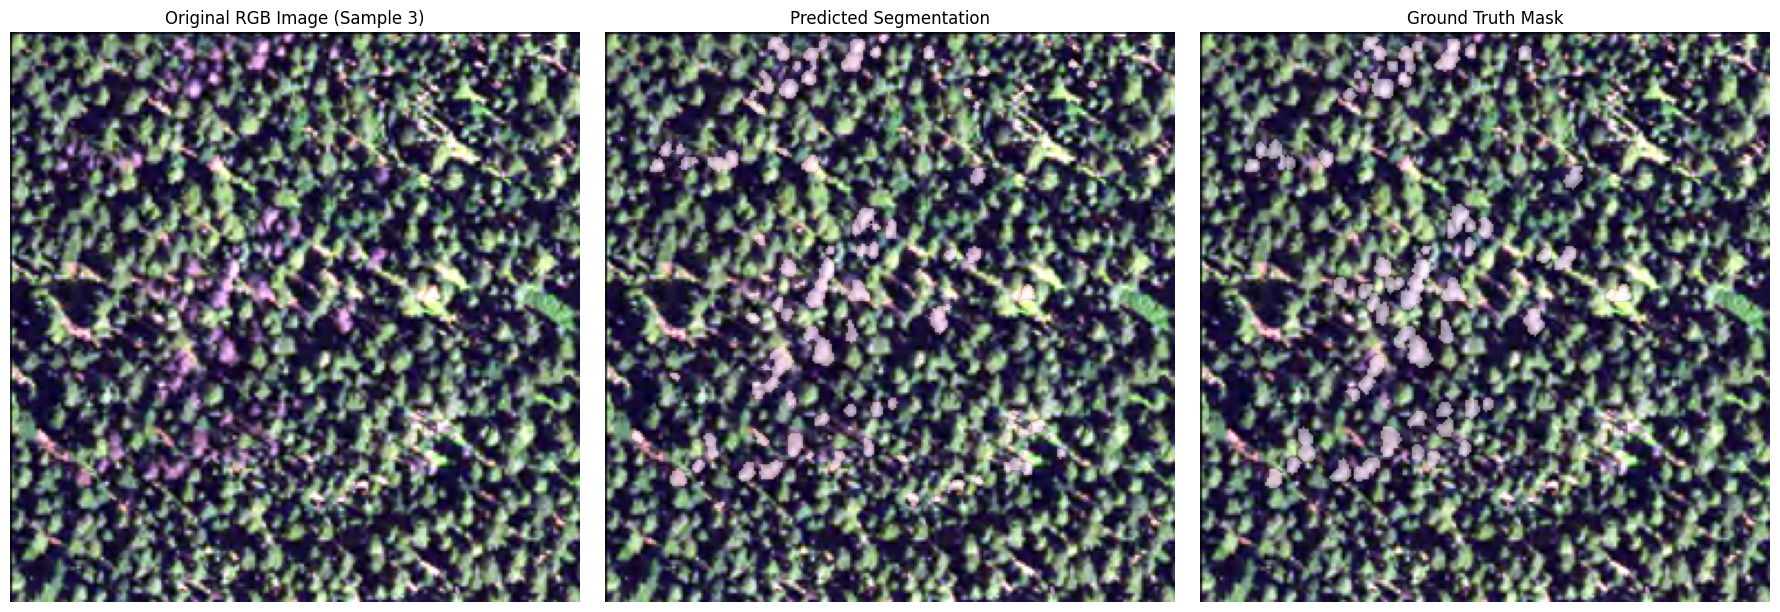

Evaluating:  25%|██▌       | 3/12 [00:01<00:03,  2.26it/s]

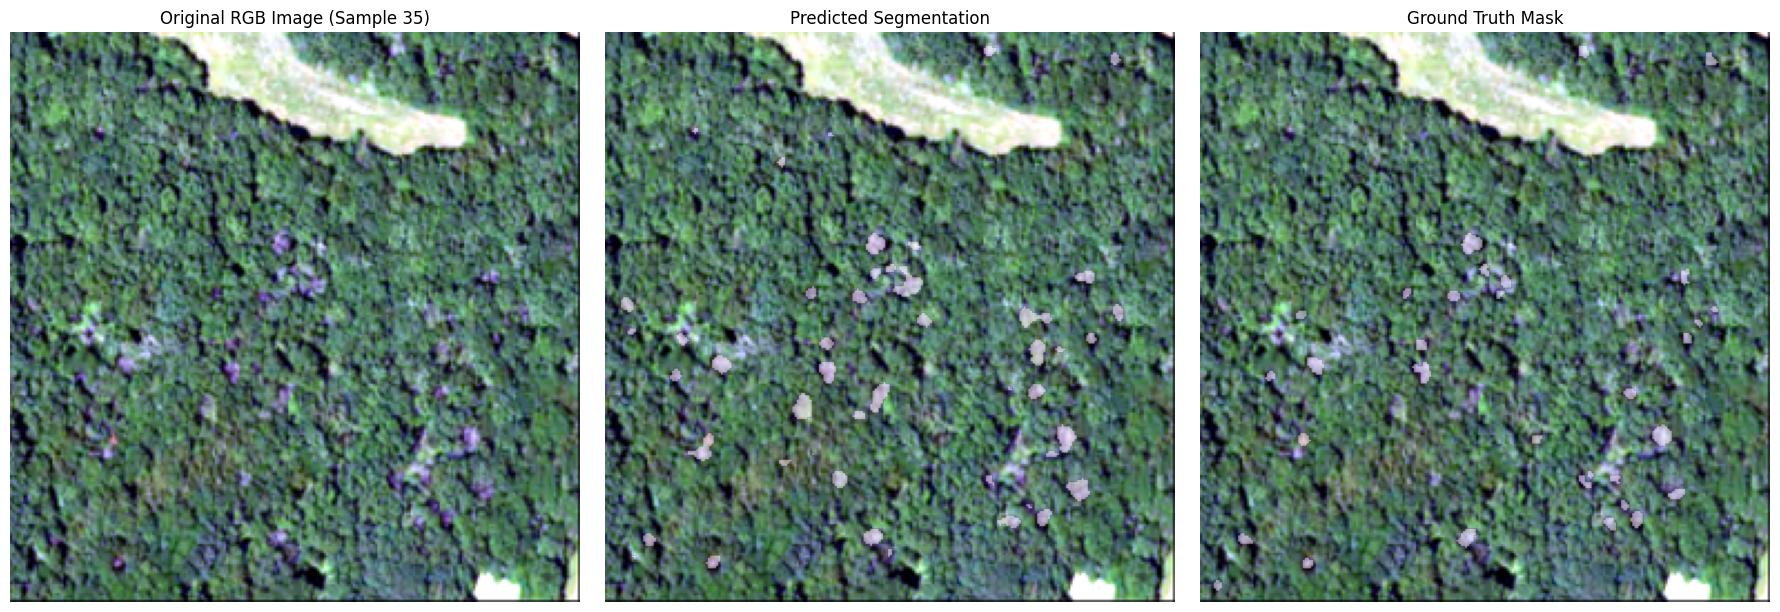

Evaluating:  67%|██████▋   | 8/12 [00:02<00:01,  3.71it/s]

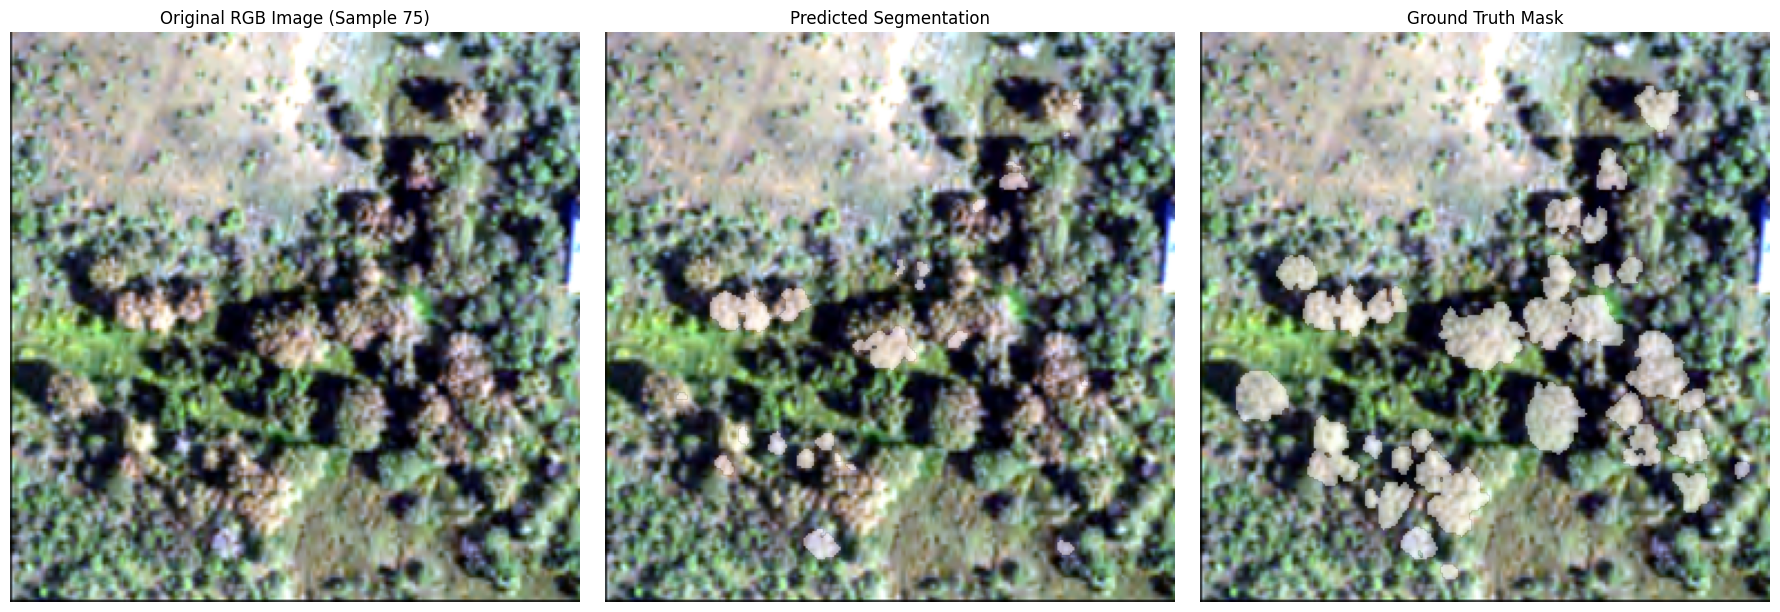

Evaluating: 100%|██████████| 12/12 [00:04<00:00,  2.98it/s]


Evaluation finished in 4.03 seconds.
Mean IoU (Jaccard Similarity Coefficient): 0.4066
The Unet's IoU is: 0.40656253695487976
This took: 4.027961015701294 to test and 145.90571546554565 to train


In [19]:
# Main running block

# Get the train test split
trainSplit, testSplit = read_and_split_data(RGB_DIR, NIR_DIR, MASK_DIR)

# train the unet model on the training set
trained_Unet, duration = train_unet_model(trainSplit)

# Evaluate the model and it's performance
mIoU, test_time = evaluate_model(trained_Unet, testSplit)

print(f"The Unet's IoU is: {mIoU}\nThis took: {test_time} to test and {duration} to train")

# Hyperparameter Tuning
Compared to the results outlined in the given paper accompanying these images, an IoU result of roughly 40% is far superior to the proposed AdaNet method from the paper. However, I wanted to see if we could get even better results by changing hyperparameters I defined originally. The parameters I can alter include the batch size, learning rate, and number of epochs.

### Batch Size
The data set that we are training on only has 444 samples and the batch sizes we are using for training was originally 8. Here are the results using a batch size of 4, 16, and 24.

Using device for training: cuda


Epoch 1/25: 100%|██████████| 89/89 [00:07<00:00, 12.37it/s]


Epoch 1/25, Loss: 0.1627


Epoch 2/25: 100%|██████████| 89/89 [00:06<00:00, 12.73it/s]


Epoch 2/25, Loss: 0.0666


Epoch 3/25: 100%|██████████| 89/89 [00:06<00:00, 13.39it/s]


Epoch 3/25, Loss: 0.0554


Epoch 4/25: 100%|██████████| 89/89 [00:07<00:00, 12.70it/s]


Epoch 4/25, Loss: 0.0527


Epoch 5/25: 100%|██████████| 89/89 [00:07<00:00, 11.53it/s]


Epoch 5/25, Loss: 0.0496


Epoch 6/25: 100%|██████████| 89/89 [00:06<00:00, 13.02it/s]


Epoch 6/25, Loss: 0.0489


Epoch 7/25: 100%|██████████| 89/89 [00:06<00:00, 13.37it/s]


Epoch 7/25, Loss: 0.0486


Epoch 8/25: 100%|██████████| 89/89 [00:06<00:00, 13.04it/s]


Epoch 8/25, Loss: 0.0475


Epoch 9/25: 100%|██████████| 89/89 [00:06<00:00, 12.77it/s]


Epoch 9/25, Loss: 0.0446


Epoch 10/25: 100%|██████████| 89/89 [00:07<00:00, 12.55it/s]


Epoch 10/25, Loss: 0.0441


Epoch 11/25: 100%|██████████| 89/89 [00:07<00:00, 11.46it/s]


Epoch 11/25, Loss: 0.0423


Epoch 12/25: 100%|██████████| 89/89 [00:07<00:00, 11.99it/s]


Epoch 12/25, Loss: 0.0412


Epoch 13/25: 100%|██████████| 89/89 [00:07<00:00, 12.06it/s]


Epoch 13/25, Loss: 0.0412


Epoch 14/25: 100%|██████████| 89/89 [00:07<00:00, 12.54it/s]


Epoch 14/25, Loss: 0.0384


Epoch 15/25: 100%|██████████| 89/89 [00:07<00:00, 12.22it/s]


Epoch 15/25, Loss: 0.0382


Epoch 16/25: 100%|██████████| 89/89 [00:07<00:00, 12.26it/s]


Epoch 16/25, Loss: 0.0366


Epoch 17/25: 100%|██████████| 89/89 [00:07<00:00, 12.27it/s]


Epoch 17/25, Loss: 0.0354


Epoch 18/25: 100%|██████████| 89/89 [00:07<00:00, 11.85it/s]


Epoch 18/25, Loss: 0.0344


Epoch 19/25: 100%|██████████| 89/89 [00:07<00:00, 11.88it/s]


Epoch 19/25, Loss: 0.0336


Epoch 20/25: 100%|██████████| 89/89 [00:07<00:00, 11.53it/s]


Epoch 20/25, Loss: 0.0317


Epoch 21/25: 100%|██████████| 89/89 [00:07<00:00, 11.77it/s]


Epoch 21/25, Loss: 0.0302


Epoch 22/25: 100%|██████████| 89/89 [00:07<00:00, 12.25it/s]


Epoch 22/25, Loss: 0.0312


Epoch 23/25: 100%|██████████| 89/89 [00:08<00:00, 10.94it/s]


Epoch 23/25, Loss: 0.0293


Epoch 24/25: 100%|██████████| 89/89 [00:07<00:00, 12.00it/s]


Epoch 24/25, Loss: 0.0281


Epoch 25/25: 100%|██████████| 89/89 [00:07<00:00, 12.33it/s]


Epoch 25/25, Loss: 0.0273
Training finished in 181.87 seconds.
Using device for evaluation: cuda
Starting model evaluation...


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 18.94it/s]


Evaluation finished in 1.22 seconds.
Mean IoU (Jaccard Similarity Coefficient): 0.4212
Using device for training: cuda


Epoch 1/25: 100%|██████████| 45/45 [00:06<00:00,  7.47it/s]


Epoch 1/25, Loss: 0.1679


Epoch 2/25: 100%|██████████| 45/45 [00:06<00:00,  7.43it/s]


Epoch 2/25, Loss: 0.0715


Epoch 3/25: 100%|██████████| 45/45 [00:06<00:00,  7.31it/s]


Epoch 3/25, Loss: 0.0603


Epoch 4/25: 100%|██████████| 45/45 [00:06<00:00,  7.35it/s]


Epoch 4/25, Loss: 0.0574


Epoch 5/25: 100%|██████████| 45/45 [00:06<00:00,  7.35it/s]


Epoch 5/25, Loss: 0.0538


Epoch 6/25: 100%|██████████| 45/45 [00:06<00:00,  7.49it/s]


Epoch 6/25, Loss: 0.0508


Epoch 7/25: 100%|██████████| 45/45 [00:06<00:00,  7.34it/s]


Epoch 7/25, Loss: 0.0516


Epoch 8/25: 100%|██████████| 45/45 [00:06<00:00,  7.25it/s]


Epoch 8/25, Loss: 0.0480


Epoch 9/25: 100%|██████████| 45/45 [00:06<00:00,  7.36it/s]


Epoch 9/25, Loss: 0.0466


Epoch 10/25: 100%|██████████| 45/45 [00:06<00:00,  7.08it/s]


Epoch 10/25, Loss: 0.0459


Epoch 11/25: 100%|██████████| 45/45 [00:06<00:00,  7.43it/s]


Epoch 11/25, Loss: 0.0438


Epoch 12/25: 100%|██████████| 45/45 [00:06<00:00,  7.49it/s]


Epoch 12/25, Loss: 0.0422


Epoch 13/25: 100%|██████████| 45/45 [00:06<00:00,  7.32it/s]


Epoch 13/25, Loss: 0.0399


Epoch 14/25: 100%|██████████| 45/45 [00:05<00:00,  7.50it/s]


Epoch 14/25, Loss: 0.0398


Epoch 15/25: 100%|██████████| 45/45 [00:06<00:00,  7.49it/s]


Epoch 15/25, Loss: 0.0388


Epoch 16/25: 100%|██████████| 45/45 [00:06<00:00,  7.19it/s]


Epoch 16/25, Loss: 0.0371


Epoch 17/25: 100%|██████████| 45/45 [00:06<00:00,  7.46it/s]


Epoch 17/25, Loss: 0.0369


Epoch 18/25: 100%|██████████| 45/45 [00:06<00:00,  7.40it/s]


Epoch 18/25, Loss: 0.0336


Epoch 19/25: 100%|██████████| 45/45 [00:06<00:00,  7.39it/s]


Epoch 19/25, Loss: 0.0325


Epoch 20/25: 100%|██████████| 45/45 [00:06<00:00,  7.40it/s]


Epoch 20/25, Loss: 0.0313


Epoch 21/25: 100%|██████████| 45/45 [00:06<00:00,  7.47it/s]


Epoch 21/25, Loss: 0.0308


Epoch 22/25: 100%|██████████| 45/45 [00:06<00:00,  7.36it/s]


Epoch 22/25, Loss: 0.0281


Epoch 23/25: 100%|██████████| 45/45 [00:06<00:00,  7.25it/s]


Epoch 23/25, Loss: 0.0268


Epoch 24/25: 100%|██████████| 45/45 [00:06<00:00,  7.20it/s]


Epoch 24/25, Loss: 0.0256


Epoch 25/25: 100%|██████████| 45/45 [00:06<00:00,  7.11it/s]


Epoch 25/25, Loss: 0.0253
Training finished in 153.11 seconds.
Using device for evaluation: cuda
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  8.69it/s]


Evaluation finished in 1.39 seconds.
Mean IoU (Jaccard Similarity Coefficient): 0.2477
Using device for training: cuda


Epoch 1/25: 100%|██████████| 23/23 [00:05<00:00,  4.16it/s]


Epoch 1/25, Loss: 0.3838


Epoch 2/25: 100%|██████████| 23/23 [00:05<00:00,  4.17it/s]


Epoch 2/25, Loss: 0.1537


Epoch 3/25: 100%|██████████| 23/23 [00:05<00:00,  4.29it/s]


Epoch 3/25, Loss: 0.1085


Epoch 4/25: 100%|██████████| 23/23 [00:05<00:00,  4.35it/s]


Epoch 4/25, Loss: 0.0874


Epoch 5/25: 100%|██████████| 23/23 [00:05<00:00,  4.42it/s]


Epoch 5/25, Loss: 0.0745


Epoch 6/25: 100%|██████████| 23/23 [00:05<00:00,  4.21it/s]


Epoch 6/25, Loss: 0.0660


Epoch 7/25: 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


Epoch 7/25, Loss: 0.0616


Epoch 8/25: 100%|██████████| 23/23 [00:05<00:00,  4.32it/s]


Epoch 8/25, Loss: 0.0590


Epoch 9/25: 100%|██████████| 23/23 [00:05<00:00,  4.24it/s]


Epoch 9/25, Loss: 0.0560


Epoch 10/25: 100%|██████████| 23/23 [00:05<00:00,  4.13it/s]


Epoch 10/25, Loss: 0.0550


Epoch 11/25: 100%|██████████| 23/23 [00:05<00:00,  4.29it/s]


Epoch 11/25, Loss: 0.0533


Epoch 12/25: 100%|██████████| 23/23 [00:05<00:00,  4.41it/s]


Epoch 12/25, Loss: 0.0523


Epoch 13/25: 100%|██████████| 23/23 [00:05<00:00,  4.16it/s]


Epoch 13/25, Loss: 0.0500


Epoch 14/25: 100%|██████████| 23/23 [00:05<00:00,  4.00it/s]


Epoch 14/25, Loss: 0.0525


Epoch 15/25: 100%|██████████| 23/23 [00:05<00:00,  4.36it/s]


Epoch 15/25, Loss: 0.0490


Epoch 16/25: 100%|██████████| 23/23 [00:05<00:00,  4.21it/s]


Epoch 16/25, Loss: 0.0537


Epoch 17/25: 100%|██████████| 23/23 [00:05<00:00,  4.26it/s]


Epoch 17/25, Loss: 0.0496


Epoch 18/25: 100%|██████████| 23/23 [00:05<00:00,  4.10it/s]


Epoch 18/25, Loss: 0.0472


Epoch 19/25: 100%|██████████| 23/23 [00:05<00:00,  4.12it/s]


Epoch 19/25, Loss: 0.0501


Epoch 20/25: 100%|██████████| 23/23 [00:05<00:00,  4.28it/s]


Epoch 20/25, Loss: 0.0455


Epoch 21/25: 100%|██████████| 23/23 [00:05<00:00,  4.17it/s]


Epoch 21/25, Loss: 0.0447


Epoch 22/25: 100%|██████████| 23/23 [00:05<00:00,  4.22it/s]


Epoch 22/25, Loss: 0.0432


Epoch 23/25: 100%|██████████| 23/23 [00:05<00:00,  4.38it/s]


Epoch 23/25, Loss: 0.0428


Epoch 24/25: 100%|██████████| 23/23 [00:05<00:00,  4.38it/s]


Epoch 24/25, Loss: 0.0421


Epoch 25/25: 100%|██████████| 23/23 [00:05<00:00,  4.02it/s]


Epoch 25/25, Loss: 0.0422
Training finished in 135.89 seconds.
Using device for evaluation: cuda
Starting model evaluation...


Evaluating: 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]


Evaluation finished in 1.32 seconds.
Mean IoU (Jaccard Similarity Coefficient): 0.3488
Using device for training: cuda


Epoch 1/25: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Epoch 1/25, Loss: 0.3881


Epoch 2/25: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Epoch 2/25, Loss: 0.1710


Epoch 3/25: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Epoch 3/25, Loss: 0.1162


Epoch 4/25: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Epoch 4/25, Loss: 0.0916


Epoch 5/25: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Epoch 5/25, Loss: 0.0775


Epoch 6/25: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Epoch 6/25, Loss: 0.0708


Epoch 7/25: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 7/25, Loss: 0.0655


Epoch 8/25: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


Epoch 8/25, Loss: 0.0612


Epoch 9/25: 100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


Epoch 9/25, Loss: 0.0587


Epoch 10/25: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Epoch 10/25, Loss: 0.0544


Epoch 11/25: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Epoch 11/25, Loss: 0.0530


Epoch 12/25: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Epoch 12/25, Loss: 0.0509


Epoch 13/25: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Epoch 13/25, Loss: 0.0483


Epoch 14/25: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


Epoch 14/25, Loss: 0.0464


Epoch 15/25: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Epoch 15/25, Loss: 0.0444


Epoch 16/25: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Epoch 16/25, Loss: 0.0422


Epoch 17/25: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Epoch 17/25, Loss: 0.0420


Epoch 18/25: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Epoch 18/25, Loss: 0.0403


Epoch 19/25: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Epoch 19/25, Loss: 0.0402


Epoch 20/25: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 20/25, Loss: 0.0387


Epoch 21/25: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Epoch 21/25, Loss: 0.0372


Epoch 22/25: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Epoch 22/25, Loss: 0.0346


Epoch 23/25: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Epoch 23/25, Loss: 0.0344


Epoch 24/25: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Epoch 24/25, Loss: 0.0326


Epoch 25/25: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Epoch 25/25, Loss: 0.0318
Training finished in 141.94 seconds.
Using device for evaluation: cuda
Starting model evaluation...


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Evaluation finished in 1.36 seconds.
Mean IoU (Jaccard Similarity Coefficient): 0.3143


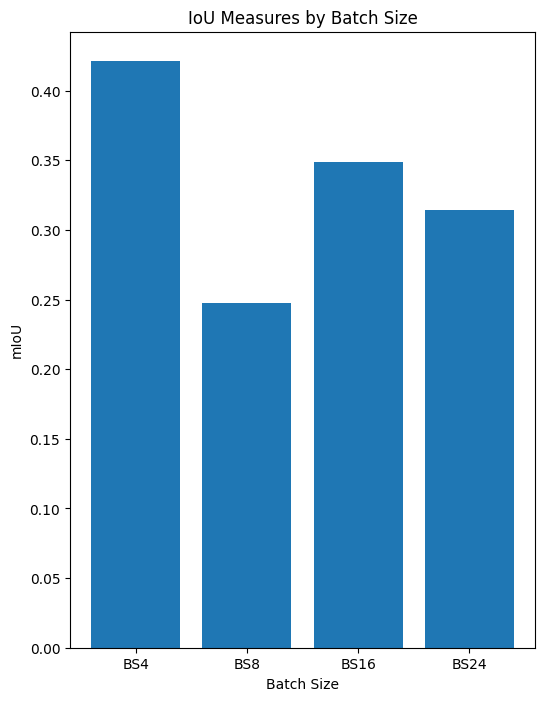

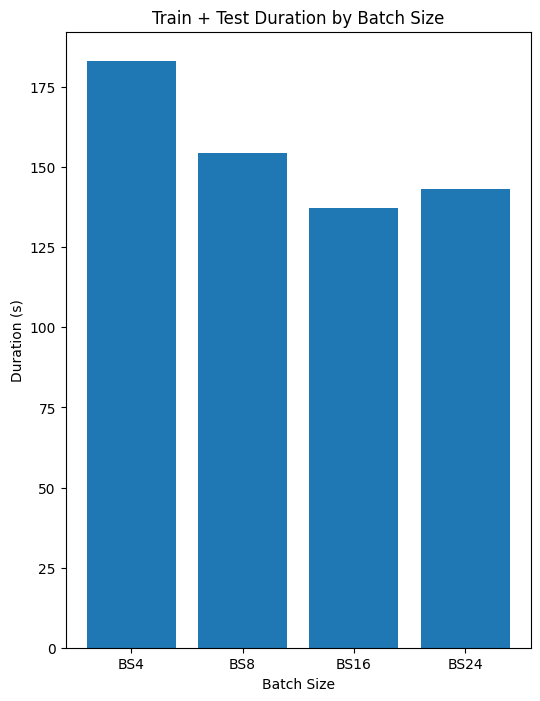

In [22]:
# Train and evaluate for different batch sizes
bs4Model, bs4Duration = train_unet_model(train, num_epochs=EPOCHS, batch_size=4, learning_rate=LR, image_size=IMAGE_SIZE)
bs4IoU, bs4test_time = evaluate_model(bs4Model, test, IMAGE_SIZE, 4, 0)

# The original code was missing a batch size of 8, so I've added it
bs8Model, bs8Duration = train_unet_model(train, num_epochs=EPOCHS, batch_size=8, learning_rate=LR, image_size=IMAGE_SIZE)
bs8IoU, bs8test_time = evaluate_model(bs8Model, test, IMAGE_SIZE, 8, 0)

bs16Model, bs16Duration = train_unet_model(train, num_epochs=EPOCHS, batch_size=16, learning_rate=LR, image_size=IMAGE_SIZE)
bs16IoU, bs16test_time = evaluate_model(bs16Model, test, IMAGE_SIZE, 16, 0)

bs24Model, bs24Duration = train_unet_model(train, num_epochs=EPOCHS, batch_size=24, learning_rate=LR, image_size=IMAGE_SIZE)
bs24IoU, bs24test_time = evaluate_model(bs24Model, test, IMAGE_SIZE, 24, 0)

# Plot the results
# Define the labels and data points correctly
batch_labels = ["BS4", "BS8", "BS16", "BS24"]

# Collect the mIoU and duration values into lists
iou_values = [bs4IoU, bs8IoU, bs16IoU, bs24IoU]
duration_values = [bs4Duration + bs4test_time, bs8Duration + bs8test_time, bs16Duration + bs16test_time, bs24Duration + bs24test_time]

# Plot the IoU results
plt.figure(figsize=(6, 8))
plt.bar(batch_labels, iou_values)
plt.title('IoU Measures by Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('mIoU')
plt.show()

# Plot the duration results
plt.figure(figsize=(6, 8))
plt.bar(batch_labels, duration_values)
plt.title('Train + Test Duration by Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Duration (s)')
plt.show()


### Learning Rate
Originally the learning rate was set to 0.001. Generally speaking decreasing the learning rate lowers the chances of overshooting to the global minima. Here are the results from setting the learning rate to 0.00075, 0.00125,  and 0.0015. From the previous tuning we know that the ideal batch size to use from the values that we tested is 4. 

Using device for training: cuda


Epoch 1/25: 100%|██████████| 89/89 [00:06<00:00, 13.03it/s]


Epoch 1/25, Loss: 0.3122


Epoch 2/25: 100%|██████████| 89/89 [00:06<00:00, 13.07it/s]


Epoch 2/25, Loss: 0.0945


Epoch 3/25: 100%|██████████| 89/89 [00:06<00:00, 13.18it/s]


Epoch 3/25, Loss: 0.0658


Epoch 4/25: 100%|██████████| 89/89 [00:06<00:00, 12.91it/s]


Epoch 4/25, Loss: 0.0567


Epoch 5/25: 100%|██████████| 89/89 [00:06<00:00, 12.88it/s]


Epoch 5/25, Loss: 0.0525


Epoch 6/25: 100%|██████████| 89/89 [00:06<00:00, 12.89it/s]


Epoch 6/25, Loss: 0.0481


Epoch 7/25: 100%|██████████| 89/89 [00:07<00:00, 12.24it/s]


Epoch 7/25, Loss: 0.0470


Epoch 8/25: 100%|██████████| 89/89 [00:06<00:00, 12.77it/s]


Epoch 8/25, Loss: 0.0439


Epoch 9/25: 100%|██████████| 89/89 [00:07<00:00, 12.04it/s]


Epoch 9/25, Loss: 0.0424


Epoch 10/25: 100%|██████████| 89/89 [00:06<00:00, 12.99it/s]


Epoch 10/25, Loss: 0.0425


Epoch 11/25: 100%|██████████| 89/89 [00:07<00:00, 12.53it/s]


Epoch 11/25, Loss: 0.0391


Epoch 12/25: 100%|██████████| 89/89 [00:07<00:00, 12.63it/s]


Epoch 12/25, Loss: 0.0371


Epoch 13/25: 100%|██████████| 89/89 [00:07<00:00, 12.54it/s]


Epoch 13/25, Loss: 0.0350


Epoch 14/25: 100%|██████████| 89/89 [00:07<00:00, 12.53it/s]


Epoch 14/25, Loss: 0.0326


Epoch 15/25: 100%|██████████| 89/89 [00:07<00:00, 12.30it/s]


Epoch 15/25, Loss: 0.0333


Epoch 16/25: 100%|██████████| 89/89 [00:07<00:00, 12.43it/s]


Epoch 16/25, Loss: 0.0299


Epoch 17/25: 100%|██████████| 89/89 [00:07<00:00, 11.66it/s]


Epoch 17/25, Loss: 0.0271


Epoch 18/25: 100%|██████████| 89/89 [00:07<00:00, 12.50it/s]


Epoch 18/25, Loss: 0.0262


Epoch 19/25: 100%|██████████| 89/89 [00:07<00:00, 12.43it/s]


Epoch 19/25, Loss: 0.0244


Epoch 20/25: 100%|██████████| 89/89 [00:07<00:00, 12.41it/s]


Epoch 20/25, Loss: 0.0232


Epoch 21/25: 100%|██████████| 89/89 [00:07<00:00, 12.32it/s]


Epoch 21/25, Loss: 0.0223


Epoch 22/25: 100%|██████████| 89/89 [00:07<00:00, 12.40it/s]


Epoch 22/25, Loss: 0.0209


Epoch 23/25: 100%|██████████| 89/89 [00:07<00:00, 12.42it/s]


Epoch 23/25, Loss: 0.0193


Epoch 24/25: 100%|██████████| 89/89 [00:07<00:00, 12.13it/s]


Epoch 24/25, Loss: 0.0188


Epoch 25/25: 100%|██████████| 89/89 [00:07<00:00, 12.13it/s]


Epoch 25/25, Loss: 0.0181
Training finished in 177.81 seconds.
Using device for evaluation: cuda
Starting model evaluation...


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.80it/s]


Evaluation finished in 1.56 seconds.
Mean IoU (Jaccard Similarity Coefficient): 0.4212
Using device for training: cuda


Epoch 1/25: 100%|██████████| 89/89 [00:07<00:00, 12.21it/s]


Epoch 1/25, Loss: 0.2161


Epoch 2/25: 100%|██████████| 89/89 [00:07<00:00, 12.30it/s]


Epoch 2/25, Loss: 0.0651


Epoch 3/25: 100%|██████████| 89/89 [00:07<00:00, 12.23it/s]


Epoch 3/25, Loss: 0.0556


Epoch 4/25: 100%|██████████| 89/89 [00:07<00:00, 12.18it/s]


Epoch 4/25, Loss: 0.0521


Epoch 5/25: 100%|██████████| 89/89 [00:07<00:00, 12.30it/s]


Epoch 5/25, Loss: 0.0492


Epoch 6/25: 100%|██████████| 89/89 [00:07<00:00, 12.20it/s]


Epoch 6/25, Loss: 0.0472


Epoch 7/25: 100%|██████████| 89/89 [00:07<00:00, 11.72it/s]


Epoch 7/25, Loss: 0.0461


Epoch 8/25: 100%|██████████| 89/89 [00:07<00:00, 11.88it/s]


Epoch 8/25, Loss: 0.0454


Epoch 9/25: 100%|██████████| 89/89 [00:07<00:00, 12.29it/s]


Epoch 9/25, Loss: 0.0446


Epoch 10/25: 100%|██████████| 89/89 [00:07<00:00, 12.28it/s]


Epoch 10/25, Loss: 0.0447


Epoch 11/25: 100%|██████████| 89/89 [00:07<00:00, 12.29it/s]


Epoch 11/25, Loss: 0.0417


Epoch 12/25: 100%|██████████| 89/89 [00:07<00:00, 12.00it/s]


Epoch 12/25, Loss: 0.0444


Epoch 13/25: 100%|██████████| 89/89 [00:07<00:00, 12.11it/s]


Epoch 13/25, Loss: 0.0400


Epoch 14/25: 100%|██████████| 89/89 [00:07<00:00, 12.26it/s]


Epoch 14/25, Loss: 0.0384


Epoch 15/25: 100%|██████████| 89/89 [00:07<00:00, 12.25it/s]


Epoch 15/25, Loss: 0.0372


Epoch 16/25: 100%|██████████| 89/89 [00:07<00:00, 11.90it/s]


Epoch 16/25, Loss: 0.0354


Epoch 17/25: 100%|██████████| 89/89 [00:07<00:00, 11.53it/s]


Epoch 17/25, Loss: 0.0368


Epoch 18/25: 100%|██████████| 89/89 [00:07<00:00, 11.95it/s]


Epoch 18/25, Loss: 0.0336


Epoch 19/25: 100%|██████████| 89/89 [00:07<00:00, 12.15it/s]


Epoch 19/25, Loss: 0.0335


Epoch 20/25: 100%|██████████| 89/89 [00:07<00:00, 11.97it/s]


Epoch 20/25, Loss: 0.0310


Epoch 21/25: 100%|██████████| 89/89 [00:07<00:00, 11.93it/s]


Epoch 21/25, Loss: 0.0318


Epoch 22/25: 100%|██████████| 89/89 [00:07<00:00, 12.11it/s]


Epoch 22/25, Loss: 0.0283


Epoch 23/25: 100%|██████████| 89/89 [00:07<00:00, 12.14it/s]


Epoch 23/25, Loss: 0.0279


Epoch 24/25: 100%|██████████| 89/89 [00:07<00:00, 11.84it/s]


Epoch 24/25, Loss: 0.0282


Epoch 25/25: 100%|██████████| 89/89 [00:07<00:00, 11.92it/s]


Epoch 25/25, Loss: 0.0267
Training finished in 184.41 seconds.
Using device for evaluation: cuda
Starting model evaluation...


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.34it/s]


Evaluation finished in 1.33 seconds.
Mean IoU (Jaccard Similarity Coefficient): 0.4212
Using device for training: cuda


Epoch 1/25: 100%|██████████| 89/89 [00:07<00:00, 11.95it/s]


Epoch 1/25, Loss: 0.1595


Epoch 2/25: 100%|██████████| 89/89 [00:07<00:00, 12.14it/s]


Epoch 2/25, Loss: 0.0645


Epoch 3/25: 100%|██████████| 89/89 [00:07<00:00, 12.07it/s]


Epoch 3/25, Loss: 0.0574


Epoch 4/25: 100%|██████████| 89/89 [00:07<00:00, 12.13it/s]


Epoch 4/25, Loss: 0.0532


Epoch 5/25: 100%|██████████| 89/89 [00:07<00:00, 11.24it/s]


Epoch 5/25, Loss: 0.0509


Epoch 6/25: 100%|██████████| 89/89 [00:07<00:00, 11.83it/s]


Epoch 6/25, Loss: 0.0497


Epoch 7/25: 100%|██████████| 89/89 [00:07<00:00, 11.92it/s]


Epoch 7/25, Loss: 0.0489


Epoch 8/25: 100%|██████████| 89/89 [00:07<00:00, 11.76it/s]


Epoch 8/25, Loss: 0.0469


Epoch 9/25: 100%|██████████| 89/89 [00:07<00:00, 11.94it/s]


Epoch 9/25, Loss: 0.0469


Epoch 10/25: 100%|██████████| 89/89 [00:07<00:00, 11.82it/s]


Epoch 10/25, Loss: 0.0471


Epoch 11/25: 100%|██████████| 89/89 [00:07<00:00, 11.83it/s]


Epoch 11/25, Loss: 0.0463


Epoch 12/25: 100%|██████████| 89/89 [00:07<00:00, 11.87it/s]


Epoch 12/25, Loss: 0.0463


Epoch 13/25: 100%|██████████| 89/89 [00:07<00:00, 11.95it/s]


Epoch 13/25, Loss: 0.0460


Epoch 14/25: 100%|██████████| 89/89 [00:07<00:00, 12.15it/s]


Epoch 14/25, Loss: 0.0462


Epoch 15/25: 100%|██████████| 89/89 [00:07<00:00, 11.96it/s]


Epoch 15/25, Loss: 0.0443


Epoch 16/25: 100%|██████████| 89/89 [00:07<00:00, 11.97it/s]


Epoch 16/25, Loss: 0.0434


Epoch 17/25: 100%|██████████| 89/89 [00:07<00:00, 12.14it/s]


Epoch 17/25, Loss: 0.0428


Epoch 18/25: 100%|██████████| 89/89 [00:07<00:00, 11.62it/s]


Epoch 18/25, Loss: 0.0408


Epoch 19/25: 100%|██████████| 89/89 [00:08<00:00, 10.39it/s]


Epoch 19/25, Loss: 0.0427


Epoch 20/25: 100%|██████████| 89/89 [00:07<00:00, 11.40it/s]


Epoch 20/25, Loss: 0.0423


Epoch 21/25: 100%|██████████| 89/89 [00:07<00:00, 11.81it/s]


Epoch 21/25, Loss: 0.0416


Epoch 22/25: 100%|██████████| 89/89 [00:07<00:00, 11.89it/s]


Epoch 22/25, Loss: 0.0412


Epoch 23/25: 100%|██████████| 89/89 [00:07<00:00, 12.21it/s]


Epoch 23/25, Loss: 0.0407


Epoch 24/25: 100%|██████████| 89/89 [00:07<00:00, 12.13it/s]


Epoch 24/25, Loss: 0.0408


Epoch 25/25: 100%|██████████| 89/89 [00:07<00:00, 11.67it/s]


Epoch 25/25, Loss: 0.0394
Training finished in 188.41 seconds.
Using device for evaluation: cuda
Starting model evaluation...


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 18.66it/s]


Evaluation finished in 1.24 seconds.
Mean IoU (Jaccard Similarity Coefficient): 0.4212


/tmp/ipykernel_81608/2185666591.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


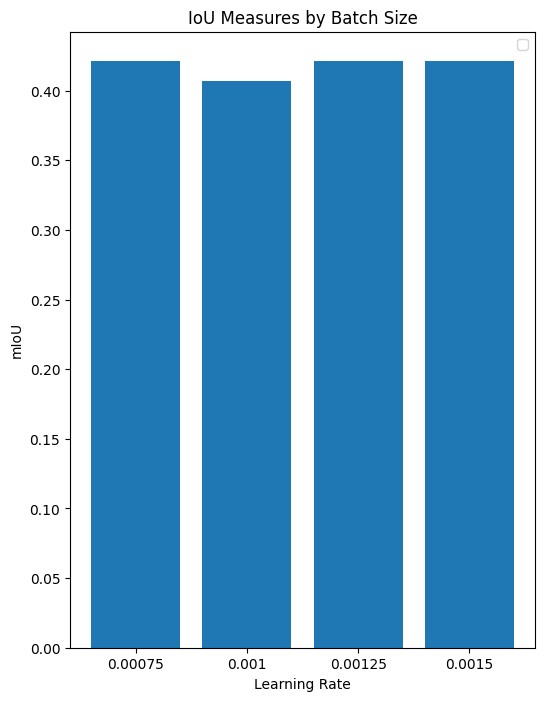

/tmp/ipykernel_81608/2185666591.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


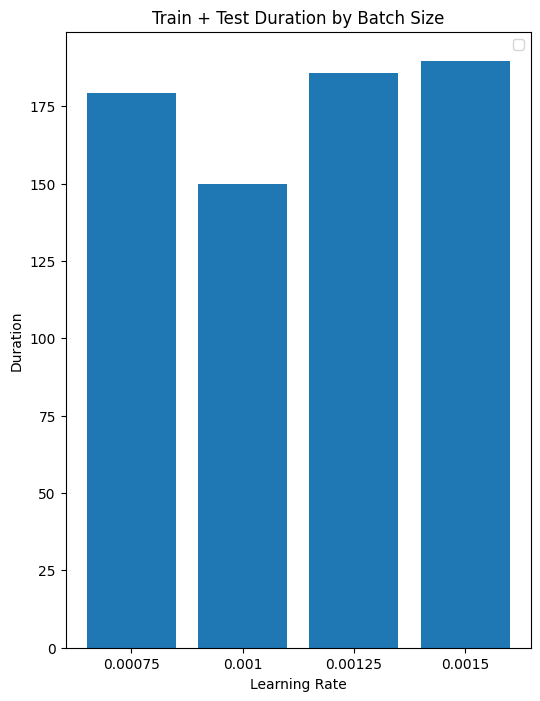

In [ ]:
# Hyperparameters
BATCH_SIZE = 4

LR1 = 0.00075
LR2 = 0.00125
LR3 = 0.0015

# Rerun the model training and evaluation
lr1Model, lr1Duration = train_unet_model(train, num_epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LR1, image_size=IMAGE_SIZE)
lr1IoU, lr1test_time = evaluate_model(bs4Model, test, IMAGE_SIZE, BATCH_SIZE, 0)

lr2Model, lr2Duration = train_unet_model(train, num_epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LR2, image_size=IMAGE_SIZE)
lr2IoU, lr2test_time = evaluate_model(bs4Model, test, IMAGE_SIZE, BATCH_SIZE, 0)

lr3Model, lr3Duration = train_unet_model(train, num_epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LR3, image_size=IMAGE_SIZE)
lr3IoU, lr3test_time = evaluate_model(bs4Model, test, IMAGE_SIZE, BATCH_SIZE, 0)

# Plot the results with different values
lr_labels = [str(LR1), "0.001", str(LR2), str(LR3)]

IoUs = [lr1IoU, mIoU, lr2IoU, lr3IoU]
times = [lr1test_time+lr1Duration, test_time+duration, lr2test_time+lr2Duration, lr3test_time+lr3Duration]

plt.figure(figsize=(6, 8))
plt.bar(lr_labels, IoUs)
plt.legend()
plt.title('IoU Measures by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('mIoU')
plt.show()

plt.figure(figsize=(6, 8))
plt.bar(lr_labels, times)
plt.legend()
plt.title('Train + Test Duration by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Duration')
plt.show()


### Number of Epochs
The default number of defaults was set to the 25. The original run took 150 seconds with a learning rate of 0.001 so it shouldn't take too long to get resolts with more epochs. Following are the results for 25, 30 and 50 epochs. We already have an ideal learning rate and batch size and now it's just a matter of maximizing the number of epochs we can run on our hardware.

Using device for training: cuda


Epoch 1/35: 100%|██████████| 178/178 [00:17<00:00, 10.44it/s]


Epoch 1/35, Loss: 0.1341


Epoch 2/35: 100%|██████████| 178/178 [00:18<00:00,  9.83it/s]


Epoch 2/35, Loss: 0.0604


Epoch 3/35: 100%|██████████| 178/178 [00:13<00:00, 12.81it/s]


Epoch 3/35, Loss: 0.0551


Epoch 4/35: 100%|██████████| 178/178 [00:15<00:00, 11.16it/s]


Epoch 4/35, Loss: 0.0538


Epoch 5/35: 100%|██████████| 178/178 [00:15<00:00, 11.52it/s]


Epoch 5/35, Loss: 0.0503


Epoch 6/35: 100%|██████████| 178/178 [00:16<00:00, 10.67it/s]


Epoch 6/35, Loss: 0.0492


Epoch 7/35: 100%|██████████| 178/178 [00:16<00:00, 11.04it/s]


Epoch 7/35, Loss: 0.0477


Epoch 8/35: 100%|██████████| 178/178 [00:17<00:00, 10.17it/s]


Epoch 8/35, Loss: 0.0473


Epoch 9/35: 100%|██████████| 178/178 [00:17<00:00, 10.23it/s]


Epoch 9/35, Loss: 0.0464


Epoch 10/35: 100%|██████████| 178/178 [00:15<00:00, 11.43it/s]


Epoch 10/35, Loss: 0.0442


Epoch 11/35: 100%|██████████| 178/178 [00:17<00:00, 10.46it/s]


Epoch 11/35, Loss: 0.0443


Epoch 12/35: 100%|██████████| 178/178 [00:16<00:00, 11.07it/s]


Epoch 12/35, Loss: 0.0431


Epoch 13/35: 100%|██████████| 178/178 [00:13<00:00, 12.87it/s]


Epoch 13/35, Loss: 0.0419


Epoch 14/35: 100%|██████████| 178/178 [00:14<00:00, 12.28it/s]


Epoch 14/35, Loss: 0.0423


Epoch 15/35: 100%|██████████| 178/178 [00:14<00:00, 12.30it/s]


Epoch 15/35, Loss: 0.0421


Epoch 16/35: 100%|██████████| 178/178 [00:12<00:00, 14.03it/s]


Epoch 16/35, Loss: 0.0414


Epoch 17/35: 100%|██████████| 178/178 [00:12<00:00, 14.27it/s]


Epoch 17/35, Loss: 0.0406


Epoch 18/35: 100%|██████████| 178/178 [00:13<00:00, 13.24it/s]


Epoch 18/35, Loss: 0.0395


Epoch 19/35: 100%|██████████| 178/178 [00:14<00:00, 12.23it/s]


Epoch 19/35, Loss: 0.0394


Epoch 20/35: 100%|██████████| 178/178 [00:11<00:00, 15.69it/s]


Epoch 20/35, Loss: 0.0387


Epoch 21/35: 100%|██████████| 178/178 [00:12<00:00, 14.00it/s]


Epoch 21/35, Loss: 0.0370


Epoch 22/35: 100%|██████████| 178/178 [00:11<00:00, 15.04it/s]


Epoch 22/35, Loss: 0.0372


Epoch 23/35: 100%|██████████| 178/178 [00:13<00:00, 13.34it/s]


Epoch 23/35, Loss: 0.0375


Epoch 24/35: 100%|██████████| 178/178 [00:14<00:00, 12.13it/s]


Epoch 24/35, Loss: 0.0357


Epoch 25/35: 100%|██████████| 178/178 [00:15<00:00, 11.39it/s]


Epoch 25/35, Loss: 0.0364


Epoch 26/35: 100%|██████████| 178/178 [00:17<00:00, 10.01it/s]


Epoch 26/35, Loss: 0.0356


Epoch 27/35: 100%|██████████| 178/178 [00:20<00:00,  8.68it/s]


Epoch 27/35, Loss: 0.0340


Epoch 28/35: 100%|██████████| 178/178 [00:13<00:00, 13.67it/s]


Epoch 28/35, Loss: 0.0338


Epoch 29/35: 100%|██████████| 178/178 [00:18<00:00,  9.53it/s]


Epoch 29/35, Loss: 0.0322


Epoch 30/35: 100%|██████████| 178/178 [00:17<00:00,  9.93it/s]


Epoch 30/35, Loss: 0.0334


Epoch 31/35: 100%|██████████| 178/178 [00:15<00:00, 11.32it/s]


Epoch 31/35, Loss: 0.0320


Epoch 32/35: 100%|██████████| 178/178 [00:13<00:00, 13.39it/s]


Epoch 32/35, Loss: 0.0324


Epoch 33/35: 100%|██████████| 178/178 [00:12<00:00, 14.71it/s]


Epoch 33/35, Loss: 0.0336


Epoch 34/35: 100%|██████████| 178/178 [00:17<00:00, 10.33it/s]


Epoch 34/35, Loss: 0.0305


Epoch 35/35: 100%|██████████| 178/178 [00:13<00:00, 13.65it/s]


Epoch 35/35, Loss: 0.0282
Training finished in 531.90 seconds.
Using device for evaluation: cuda
Starting model evaluation...


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 12.23it/s]


Evaluation finished in 1.89 seconds.
Mean IoU (Jaccard Similarity Coefficient): 0.4212
Using device for training: cuda


Epoch 1/50: 100%|██████████| 178/178 [00:11<00:00, 15.56it/s]


Epoch 1/50, Loss: 0.1929


Epoch 2/50: 100%|██████████| 178/178 [00:10<00:00, 16.22it/s]


Epoch 2/50, Loss: 0.0650


Epoch 3/50: 100%|██████████| 178/178 [00:11<00:00, 15.92it/s]


Epoch 3/50, Loss: 0.0564


Epoch 4/50: 100%|██████████| 178/178 [00:11<00:00, 16.02it/s]


Epoch 4/50, Loss: 0.0528


Epoch 5/50: 100%|██████████| 178/178 [00:11<00:00, 16.10it/s]


Epoch 5/50, Loss: 0.0515


Epoch 6/50: 100%|██████████| 178/178 [00:14<00:00, 12.29it/s]


Epoch 6/50, Loss: 0.0495


Epoch 7/50: 100%|██████████| 178/178 [00:11<00:00, 14.93it/s]


Epoch 7/50, Loss: 0.0492


Epoch 8/50: 100%|██████████| 178/178 [00:11<00:00, 15.96it/s]


Epoch 8/50, Loss: 0.0469


Epoch 9/50: 100%|██████████| 178/178 [00:10<00:00, 16.59it/s]


Epoch 9/50, Loss: 0.0460


Epoch 10/50: 100%|██████████| 178/178 [00:10<00:00, 16.32it/s]


Epoch 10/50, Loss: 0.0453


Epoch 11/50: 100%|██████████| 178/178 [00:10<00:00, 16.44it/s]


Epoch 11/50, Loss: 0.0468


Epoch 12/50: 100%|██████████| 178/178 [00:10<00:00, 16.28it/s]


Epoch 12/50, Loss: 0.0434


Epoch 13/50: 100%|██████████| 178/178 [00:16<00:00, 10.48it/s]


Epoch 13/50, Loss: 0.0435


Epoch 14/50: 100%|██████████| 178/178 [00:16<00:00, 10.84it/s]


Epoch 14/50, Loss: 0.0422


Epoch 15/50: 100%|██████████| 178/178 [00:10<00:00, 16.55it/s]


Epoch 15/50, Loss: 0.0417


Epoch 16/50: 100%|██████████| 178/178 [00:11<00:00, 15.89it/s]


Epoch 16/50, Loss: 0.0421


Epoch 17/50: 100%|██████████| 178/178 [00:11<00:00, 16.18it/s]


Epoch 17/50, Loss: 0.0407


Epoch 18/50: 100%|██████████| 178/178 [00:11<00:00, 15.06it/s]


Epoch 18/50, Loss: 0.0405


Epoch 19/50: 100%|██████████| 178/178 [00:11<00:00, 15.08it/s]


Epoch 19/50, Loss: 0.0400


Epoch 20/50: 100%|██████████| 178/178 [00:11<00:00, 15.76it/s]


Epoch 20/50, Loss: 0.0381


Epoch 21/50: 100%|██████████| 178/178 [00:10<00:00, 16.28it/s]


Epoch 21/50, Loss: 0.0380


Epoch 22/50: 100%|██████████| 178/178 [00:11<00:00, 16.01it/s]


Epoch 22/50, Loss: 0.0385


Epoch 23/50: 100%|██████████| 178/178 [00:11<00:00, 15.23it/s]


Epoch 23/50, Loss: 0.0371


Epoch 24/50: 100%|██████████| 178/178 [00:10<00:00, 16.37it/s]


Epoch 24/50, Loss: 0.0377


Epoch 25/50: 100%|██████████| 178/178 [00:12<00:00, 14.40it/s]


Epoch 25/50, Loss: 0.0365


Epoch 26/50: 100%|██████████| 178/178 [00:11<00:00, 15.80it/s]


Epoch 26/50, Loss: 0.0360


Epoch 27/50: 100%|██████████| 178/178 [00:10<00:00, 16.48it/s]


Epoch 27/50, Loss: 0.0349


Epoch 28/50: 100%|██████████| 178/178 [00:10<00:00, 16.21it/s]


Epoch 28/50, Loss: 0.0345


Epoch 29/50: 100%|██████████| 178/178 [00:11<00:00, 16.14it/s]


Epoch 29/50, Loss: 0.0346


Epoch 30/50: 100%|██████████| 178/178 [00:10<00:00, 16.19it/s]


Epoch 30/50, Loss: 0.0331


Epoch 31/50: 100%|██████████| 178/178 [00:11<00:00, 14.92it/s]


Epoch 31/50, Loss: 0.0316


Epoch 32/50: 100%|██████████| 178/178 [00:11<00:00, 16.02it/s]


Epoch 32/50, Loss: 0.0312


Epoch 33/50: 100%|██████████| 178/178 [00:10<00:00, 16.52it/s]


Epoch 33/50, Loss: 0.0314


Epoch 34/50: 100%|██████████| 178/178 [00:10<00:00, 16.27it/s]


Epoch 34/50, Loss: 0.0344


Epoch 35/50: 100%|██████████| 178/178 [00:11<00:00, 15.10it/s]


Epoch 35/50, Loss: 0.0302


Epoch 36/50: 100%|██████████| 178/178 [00:10<00:00, 16.72it/s]


Epoch 36/50, Loss: 0.0287


Epoch 37/50: 100%|██████████| 178/178 [00:11<00:00, 16.08it/s]


Epoch 37/50, Loss: 0.0275


Epoch 38/50: 100%|██████████| 178/178 [00:10<00:00, 16.49it/s]


Epoch 38/50, Loss: 0.0270


Epoch 39/50: 100%|██████████| 178/178 [00:10<00:00, 17.01it/s]


Epoch 39/50, Loss: 0.0256


Epoch 40/50: 100%|██████████| 178/178 [00:10<00:00, 16.85it/s]


Epoch 40/50, Loss: 0.0259


Epoch 41/50: 100%|██████████| 178/178 [00:10<00:00, 17.06it/s]


Epoch 41/50, Loss: 0.0257


Epoch 42/50: 100%|██████████| 178/178 [00:11<00:00, 14.98it/s]


Epoch 42/50, Loss: 0.0239


Epoch 43/50: 100%|██████████| 178/178 [00:11<00:00, 15.96it/s]


Epoch 43/50, Loss: 0.0229


Epoch 44/50: 100%|██████████| 178/178 [00:10<00:00, 16.40it/s]


Epoch 44/50, Loss: 0.0231


Epoch 45/50: 100%|██████████| 178/178 [00:11<00:00, 15.96it/s]


Epoch 45/50, Loss: 0.0252


Epoch 46/50: 100%|██████████| 178/178 [00:11<00:00, 15.29it/s]


Epoch 46/50, Loss: 0.0216


Epoch 47/50: 100%|██████████| 178/178 [00:11<00:00, 15.38it/s]


Epoch 47/50, Loss: 0.0215


Epoch 48/50: 100%|██████████| 178/178 [00:10<00:00, 16.25it/s]


Epoch 48/50, Loss: 0.0197


Epoch 49/50: 100%|██████████| 178/178 [00:12<00:00, 14.31it/s]


Epoch 49/50, Loss: 0.0203


Epoch 50/50: 100%|██████████| 178/178 [00:10<00:00, 16.49it/s]


Epoch 50/50, Loss: 0.0191
Training finished in 573.30 seconds.
Using device for evaluation: cuda
Starting model evaluation...


Evaluating: 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


Evaluation finished in 1.67 seconds.
Mean IoU (Jaccard Similarity Coefficient): 0.4212


/tmp/ipykernel_81608/1072171541.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


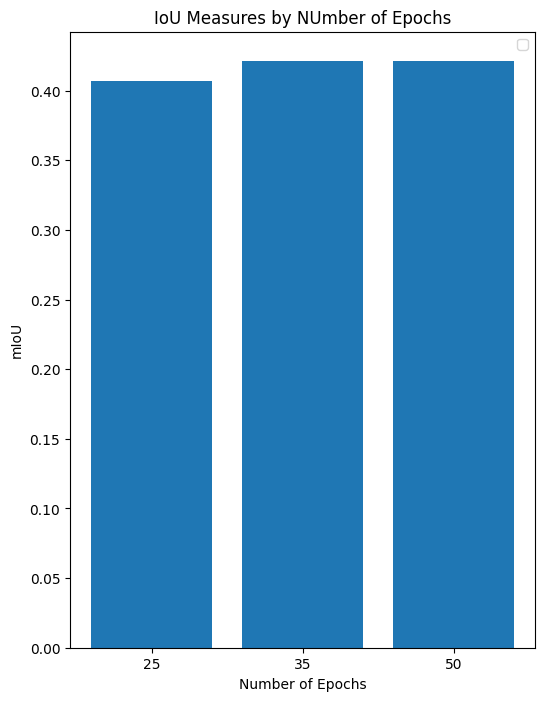

/tmp/ipykernel_81608/1072171541.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


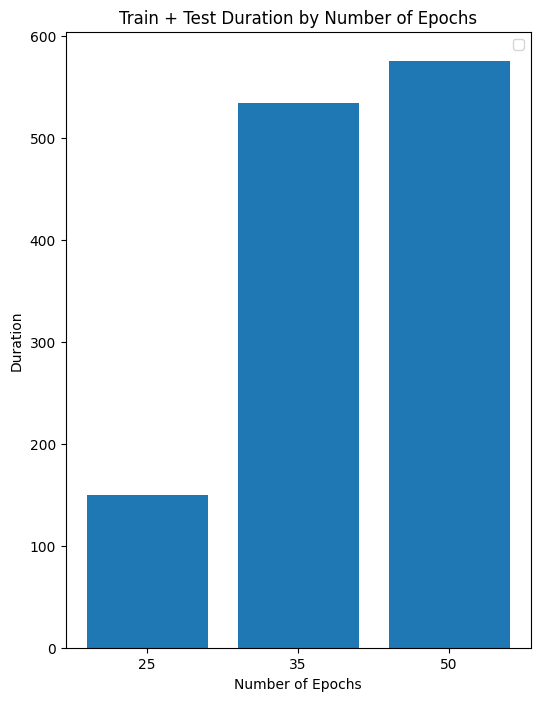

In [ ]:
# Hyperparameters from previous tests
BATCH_SIZE = 2
LR = 0.00075

E1 = 35
E2 = 50

# Rerun the model training and evaluation
e35Model, e35Duration = train_unet_model(train, num_epochs=E1, batch_size=BATCH_SIZE, learning_rate=LR, image_size=IMAGE_SIZE)
e35IoU, e35test_time = evaluate_model(bs4Model, test, IMAGE_SIZE, 4, 0)
e50Model, e50Duration = train_unet_model(train, num_epochs=E2, batch_size=BATCH_SIZE, learning_rate=LR, image_size=IMAGE_SIZE)
e50IoU, e50test_time = evaluate_model(bs4Model, test, IMAGE_SIZE, 16, 0)

# Plot the results with different values
epoch_labels = ["25", str(E1), str(E2)]

eIoUs = [mIoU, e35IoU, e50IoU]
eTimes = [duration+test_time, e35Duration+e35test_time, e50Duration+e50test_time]

plt.figure(figsize=(6, 8))
plt.bar(epoch_labels, eIoUs)
plt.legend()
plt.title('IoU Measures by Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('mIoU')
plt.show()

plt.figure(figsize=(6, 8))
plt.bar(epoch_labels, eTimes) 
plt.legend()
plt.title('Train + Test Duration by Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Duration')
plt.show()


## Ideal Tuning
From this hyperparameter tuning we saw an ideal result of from the following values:

- Batch Size = 4

- Learning Rate = 0.0075

- Epochs = 35

Throughout the trial runs we found that the results tetered between 40%-42%. 

In [ ]:
# Final results

# Highest IoU from the batch tuning
